In [ ]:
!wget https://zenodo.org/records/15613160/files/GaAs.vasp
!wget https://zenodo.org/records/15613160/files/GaAs_rho_ks.xsf
!wget https://zenodo.org/records/15613160/files/GaAs_rho_lmg.xsf
!wget https://zenodo.org/records/15613160/files/GaAs.tddft.out

## Visualize structure with ASE

In [1]:
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from io import BytesIO
from ase.io import read
import numpy as np
import matplotlib.pyplot as plt

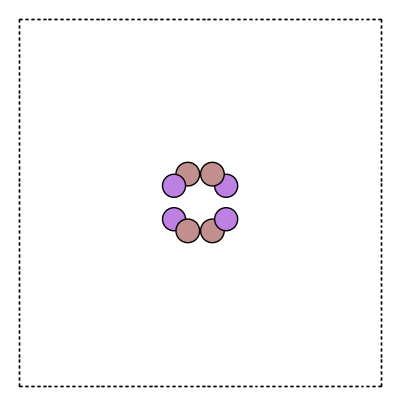

In [2]:
atoms = read('GaAs8.vasp')
fig, ax = plt.subplots(figsize=(5, 5))
plot_atoms(atoms, ax, radii=0.5, rotation=('0x,0y,0z'))
plt.axis('off')
buf = BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)
fig.savefig('GaAs.png')

## Compare electron density from KS and LMGP

In [11]:
from dftpy.formats import io
rho_ks = io.read_density('GaAs_rho_ks.xsf', full=True)
rho_lmgp = io.read_density('GaAs_rho_lmgp.xsf', full=True)

In [12]:
rho_ks.grid.nr, rho_lmgp.grid.nr

(array([108, 108, 100]), array([88, 88, 84]))

In [13]:
from dftpy.grid import DirectGrid
from dftpy.utils import grid_map_data
grid = DirectGrid(rho_lmgp.grid.lattice, nr=rho_lmgp.grid.nr)
rho_ks = grid_map_data(rho_ks, grid=grid)

#### Electron density difference

In [15]:
0.5 * (np.abs(rho_ks-rho_lmgp)).integral()

0.990595535295793

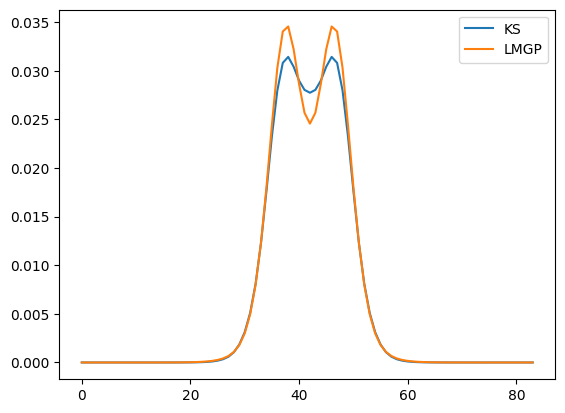

In [20]:
plt.plot(rho_ks[44,44,:].ravel(), label='KS')
plt.plot(rho_lmgp[44,44,:].ravel(), label='LMGP')
plt.legend()

In [22]:

from dftpy.td.utils import calc_spectra_mu
import qepy
from dftpy.constants import TIME_CONV, LEN_CONV, ENERGY_CONV
as2au = TIME_CONV['s']['au']*1e-18
bohr = LEN_CONV['Angstrom']['Bohr']
k = 0.01*bohr
interval = 1.0 * as2au
ha = ENERGY_CONV['Hartree']['eV']

In [23]:
direction = 0 # 0, 1, 2 means x, y, z-direction, respectively
k = 0.01*bohr # kick_strength in a.u.
interval = 1.0 * as2au
output = 'GaAs.tddft.out'

In [24]:
mu = []
with open(output, 'r') as fh:
    for line in fh:
        if line[:4]=='DIP ':
            mu.append(list(map(float, line.split()[-3:])))
mu = np.asarray(mu)

Text(0, 0.5, 'Dipole Moment (au)')

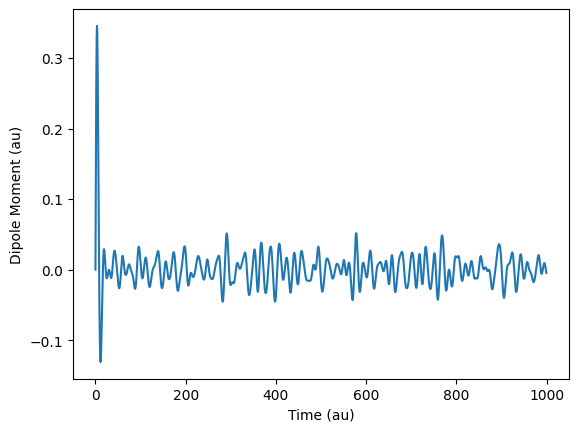

In [25]:
max_steps = len(mu)-1
t = np.linspace(0, interval * max_steps, max_steps + 1)
delta_mu = mu[:,0] - mu[0,0]
plt.plot(t, delta_mu)
plt.xlabel('Time (au)')
plt.ylabel('Dipole Moment (au)')

In [7]:
max_steps, 0.02*(as2au**2)

(24174, 3.418218299967324e-05)

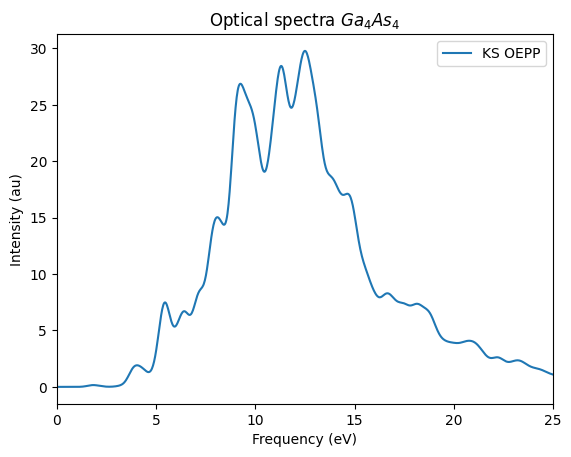

In [10]:
sigma = 0.03*(as2au**2)
omega, spectra = calc_spectra_mu(delta_mu, interval, kick=k, emax=2, sigma=sigma)
plt.plot(omega*ha, spectra, '-', label='KS OEPP')
plt.xlabel('Frequency (eV)')
plt.ylabel('Intensity (au)')
plt.xlim(0, 25)
plt.title(r'Optical spectra $Ga_4As_4$')
plt.legend()